# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [0]:
final[30:50]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,1,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,1,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,1,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,1,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,1,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,1,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,1,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [0]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364171, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [0]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
conn.close()
    
with open('positive_words.pkl', 'wb') as f:
    pickle.dump(all_positive_words, f)
with open('negitive_words.pkl', 'wb') as f:
    pickle.dump(all_negative_words, f)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 116756)
the number of unique words  116756


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.993915855884552), ('think', 0.9937940835952759), ('wonderful', 0.9935376048088074), ('care', 0.9930582046508789), ('calorie', 0.9928725361824036), ('anything', 0.9927980899810791), ('heaven', 0.9927351474761963), ('healthier', 0.9926670789718628), ('bad', 0.9926649928092957), ('especially', 0.9925721287727356)]
[('de', 0.9994063377380371), ('american', 0.9993734359741211), ('level', 0.999372124671936), ('must', 0.9993143677711487), ('normal', 0.999298095703125), ('world', 0.999297559261322), ('part', 0.9992881417274475), ('style', 0.9992705583572388), ('middle', 0.9992623925209045), ('experience', 0.9992586374282837)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████| 4986/4986 [00:17<00:00, 283.63it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 4986/4986 [01:33<00:00, 53.47it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [5]:
con = sqlite3.connect('final.sqlite')
final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con)
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


# Random Sampling Of Dataset

In [6]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 20k datapoints

# We will collect different 20k rows without repetition from time_sorted_data dataframe
my_final = time_sorted_data[:50000]
print(my_final.shape)
my_final.head()

(50000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


# splitting data

In [0]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0,shuffle=False)

# bow

In [8]:
#Text -> Uni gram Vectors
uni_gram = CountVectorizer(min_df = 10) 
X_train_bow = uni_gram.fit_transform(X_train)
#Normalize Data
X_train_bow = preprocessing.normalize(X_train_bow)
print("Train Data Size: ",X_train.shape)
X_test_bow = uni_gram.transform(X_test)
#Normalize Data
X_test_bow = preprocessing.normalize(X_test_bow)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (35000,)
Test Data Size:  (15000,)


In [9]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_bow):
#     print("%s %s" % (train, cv))
    print(X_train_bow[train].shape, X_train_bow[cv].shape)

(3190, 5250) (3181, 5250)
(6371, 5250) (3181, 5250)
(9552, 5250) (3181, 5250)
(12733, 5250) (3181, 5250)
(15914, 5250) (3181, 5250)
(19095, 5250) (3181, 5250)
(22276, 5250) (3181, 5250)
(25457, 5250) (3181, 5250)
(28638, 5250) (3181, 5250)
(31819, 5250) (3181, 5250)


## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [10]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train_bow,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.54 µs
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 78.76%


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 47.8min finished


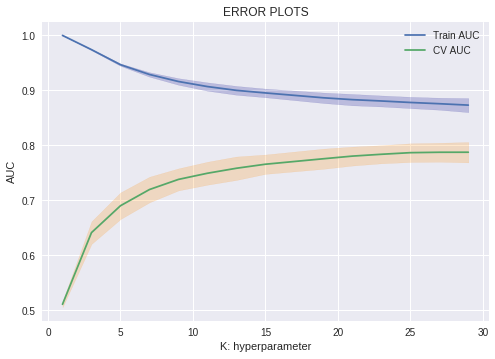

In [11]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
K = [1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]
train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(X_train_bow,Y_train)
Y_pred = knn.predict(X_test_bow)
X_pred=knn.predict(X_train_bow)

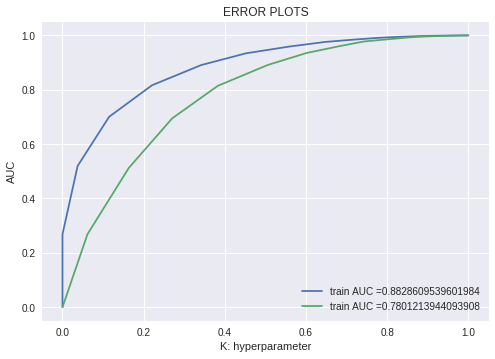

In [14]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Accuracy on test set: 88.267%
Precision on test set: 0.883
Recall on test set: 1.000
F1-Score on test set: 0.830
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



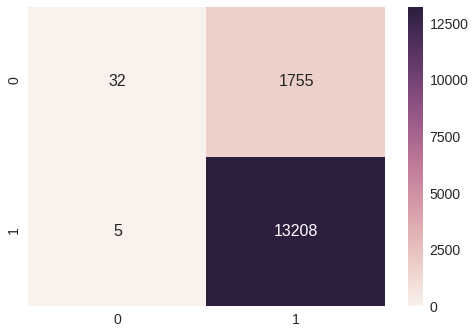

In [15]:
#Testing Accuracy on Test data
#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on train set: 89.397%
Precision on train set: 0.894
Recall on train set: 1.000
F1-Score on train set: 0.848
Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



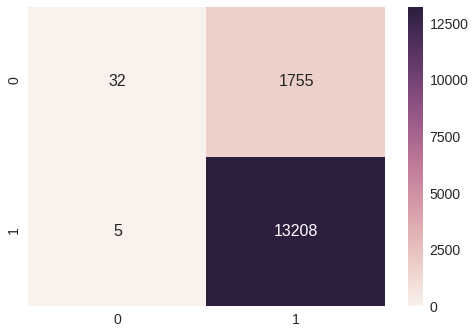

In [16]:
#Testing accuracy on train data
print("Accuracy on train set: %0.3f%%"%(accuracy_score(Y_train, X_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(Y_train, X_pred,pos_label=1)))
print("Recall on train set: %0.3f"%(recall_score(Y_train, X_pred,pos_label=1)))
print("F1-Score on train set: %0.3f"%(f1_score(Y_train, X_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

TFIDF

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [17]:
# Please write all the code with proper documentation
%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10) #Using bi-grams
X_train_tfidf = tfidf.fit_transform(X_train)
#Normalize Data
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_train.shape)
X_test_tfidf = tfidf.transform(X_test)
#Normalize Data
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("Test Data Size: ",X_test.shape)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs
Train Data Size:  (35000,)
Test Data Size:  (15000,)


In [18]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train_tfidf):
#     print("%s %s" % (train, cv))
    print(X_train_tfidf[train].shape, X_train_tfidf[cv].shape)

(3190, 5250) (3181, 5250)
(6371, 5250) (3181, 5250)
(9552, 5250) (3181, 5250)
(12733, 5250) (3181, 5250)
(15914, 5250) (3181, 5250)
(19095, 5250) (3181, 5250)
(22276, 5250) (3181, 5250)
(25457, 5250) (3181, 5250)
(28638, 5250) (3181, 5250)
(31819, 5250) (3181, 5250)


In [21]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(X_train_tfidf,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 77.54%


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 51.4min finished


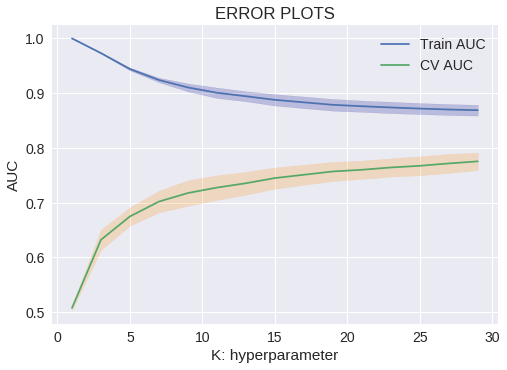

In [22]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
K = [1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]
train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(X_train_tfidf,Y_train)
Y_pred = knn.predict(X_test_tfidf)
X_pred=knn.predict(X_train_tfidf)

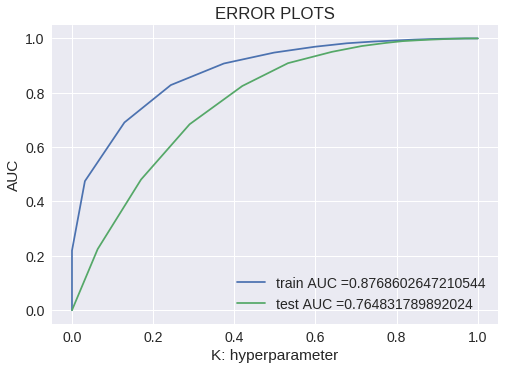

In [26]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Accuracy on test set: 88.460%
Precision on test set: 0.884
Recall on test set: 1.000
F1-Score on test set: 0.834
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



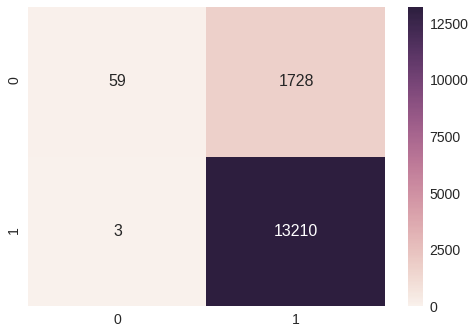

In [27]:
#Testing Accuracy on Test data

print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 89.514%
Precision on test set: 0.895
Recall on test set: 1.000
F1-Score on test set: 0.851
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



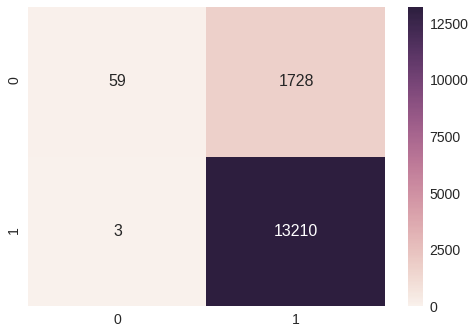

In [28]:
#Testing accuracy on train data
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_train, X_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_train, X_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_train, X_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_train, X_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [29]:
# Please write all the code with proper documentation
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  7936


In [0]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)    

In [0]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

In [34]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(train_vectors,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 82.98%


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 27.4min finished


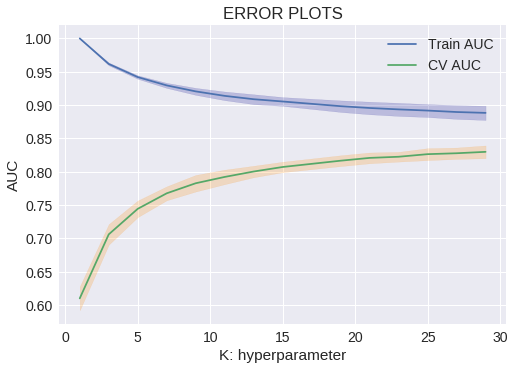

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(train_vectors,Y_train)
Y_pred = knn.predict(test_vectors)
X_pred = knn.predict(train_vectors)

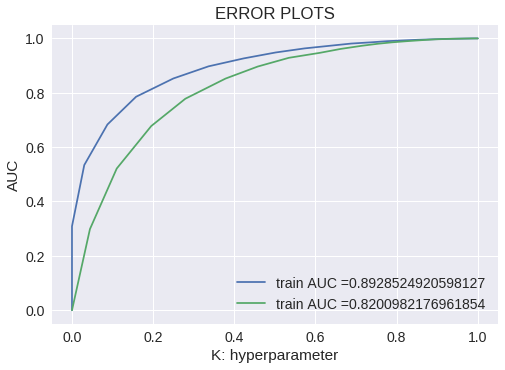

In [38]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Accuracy on test set: 89.120%
Precision on test set: 0.894
Recall on test set: 0.995
F1-Score on test set: 0.855
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



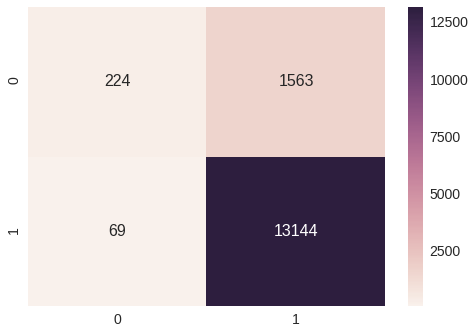

In [39]:
#Testing Accuracy on Test data
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 90.214%
Precision on test set: 0.905
Recall on test set: 0.995
F1-Score on test set: 0.871
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



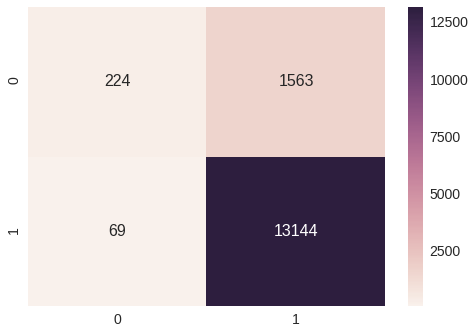

In [40]:
#Testing accuracy on train data
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_train, X_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_train, X_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_train, X_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_train, X_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1 

In [0]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  

In [0]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

In [45]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
gsv.fit(tfidf_train_vectors,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.39 µs
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best HyperParameter:  {'n_neighbors': 29}
Best Accuracy: 79.15%


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 27.4min finished


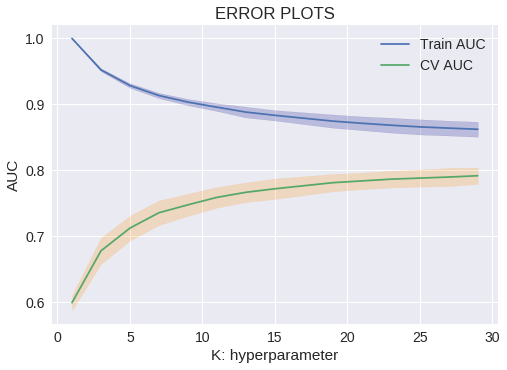

In [46]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(tfidf_train_vectors,Y_train)
Y_pred = knn.predict(tfidf_test_vectors)
X_pred = knn.predict(tfidf_train_vectors)

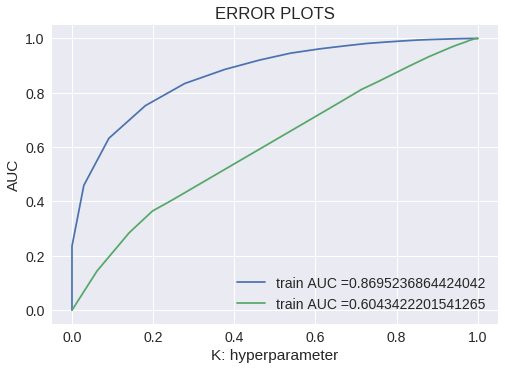

In [49]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(tfidf_train_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(tfidf_test_vectors)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Accuracy on test set: 87.820%
Precision on test set: 0.882
Recall on test set: 0.995
F1-Score on test set: 0.827
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



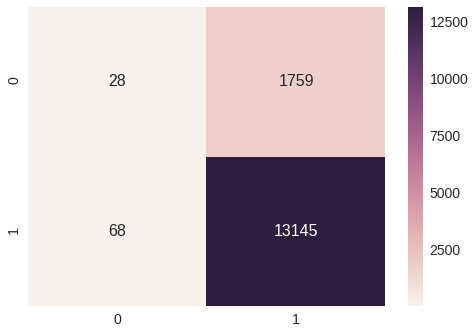

In [50]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test set: 89.946%
Precision on test set: 0.902
Recall on test set: 0.996
F1-Score on test set: 0.865
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



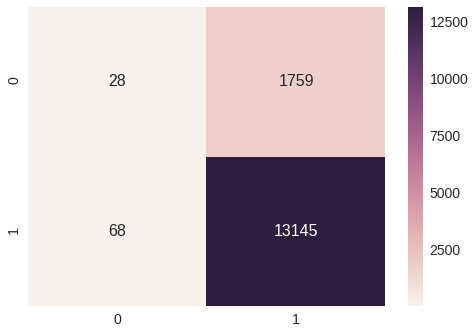

In [51]:
#Testing accuracy on train data
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_train, X_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_train, X_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_train, X_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_train, X_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## [5.2] Applying KNN kd-tree

In [53]:
my_final = time_sorted_data[:20000]
my_final.shape

(20000, 12)

In [0]:
x = my_final['CleanedText'].values
y = my_final['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0,shuffle=False)

In [55]:
#Text -> Uni gram Vectors
uni_gram = CountVectorizer(min_df = 10) 
X_train_bow = uni_gram.fit_transform(X_train)
#Normalize Data
X_train_bow = preprocessing.normalize(X_train_bow)
print("Train Data Size: ",X_train.shape)
X_test_bow = uni_gram.transform(X_test)
#Normalize Data
X_test_bow = preprocessing.normalize(X_test_bow)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (14000,)
Test Data Size:  (6000,)


### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 1</font>

In [56]:
# Please write all the code with proper documentation
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(X_train_bow)
X_test_vec_dense = svd.transform(X_test_bow)


knn = KNeighborsClassifier(algorithm='kd_tree')
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train_vec_dense,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best HyperParameter:  {'n_neighbors': 27}
Best Accuracy: 88.81%


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 33.4min finished


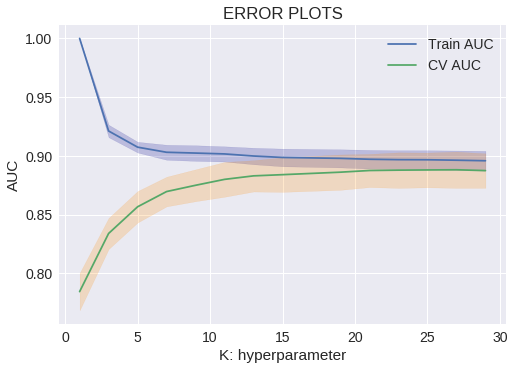

In [57]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
K = [1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]
train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=27,algorithm='kd_tree')
knn.fit(X_train_vec_dense,Y_train)
Y_pred = knn.predict(X_test_vec_dense)
X_pred = knn.predict(X_train_vec_dense)

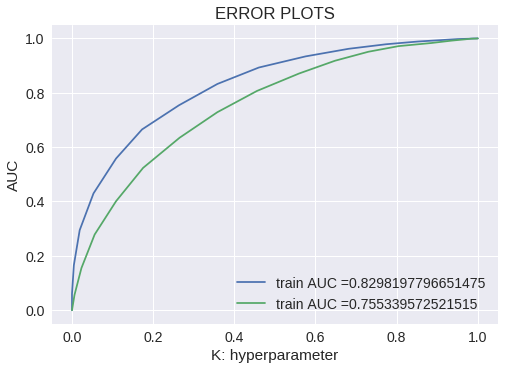

In [60]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(X_train_vec_dense)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test_vec_dense)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Accuracy on test set: 89.217%
Precision on test set: 0.898
Recall on test set: 0.992
F1-Score on test set: 0.853
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



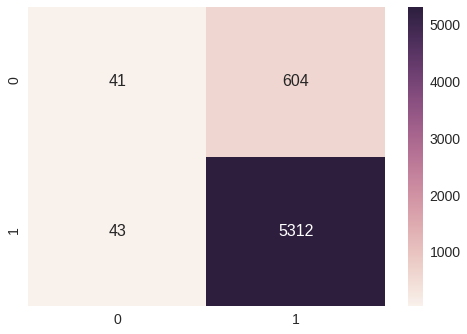

In [61]:
#Testing Accuracy on Test data


print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on train set: 89.500%
Precision on train set: 0.899
Recall on train set: 0.994
F1-Score on train set: 0.857
Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



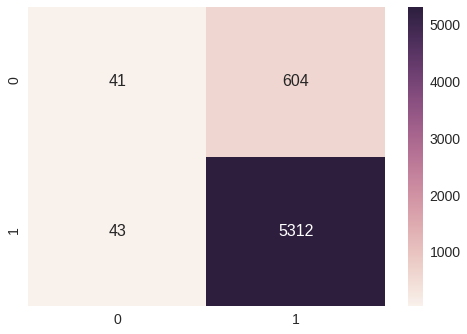

In [62]:
#Testing accuracy on train data
print("Accuracy on train set: %0.3f%%"%(accuracy_score(Y_train, X_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(Y_train, X_pred,pos_label=1)))
print("Recall on train set: %0.3f"%(recall_score(Y_train, X_pred,pos_label=1)))
print("F1-Score on train set: %0.3f"%(f1_score(Y_train, X_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 2</font>

In [63]:
# Please write all the code with proper documentation
%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10) #Using bi-grams
X_train_tfidf = tfidf.fit_transform(X_train)
#Normalize Data
X_train_tfidf = preprocessing.normalize(X_train_tfidf)
print("Train Data Size: ",X_train.shape)
X_test_tfidf = tfidf.transform(X_test)
#Normalize Data
X_test_tfidf = preprocessing.normalize(X_test_tfidf)
print("Test Data Size: ",X_test.shape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Train Data Size:  (14000,)
Test Data Size:  (6000,)


In [64]:
# Please write all the code with proper documentation
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
X_train_vec_dense = svd.fit_transform(X_train_tfidf)
X_test_vec_dense = svd.transform(X_test_tfidf)

%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit
knn = KNeighborsClassifier(algorithm='kd_tree',n_jobs=2)
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train_vec_dense,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best HyperParameter:  {'n_neighbors': 27}
Best Accuracy: 88.87%


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed: 26.9min finished


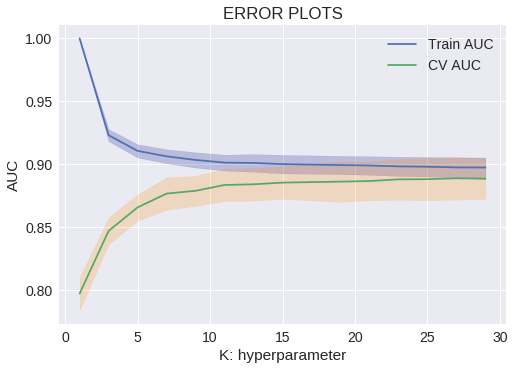

In [65]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:
knn = KNeighborsClassifier(n_neighbors=27,algorithm='kd_tree')
knn.fit(X_train_vec_dense,Y_train)
Y_pred = knn.predict(X_test_vec_dense)
X_pred = knn.predict(X_train_vec_dense)

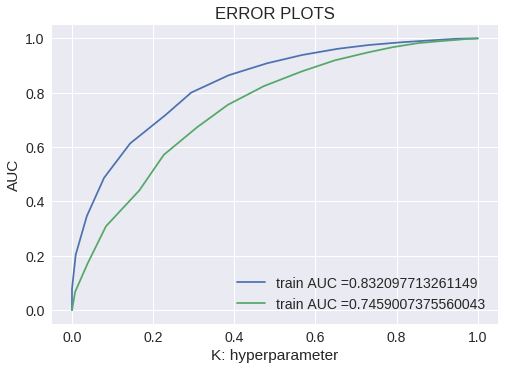

In [68]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(X_train_vec_dense)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test_vec_dense)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Accuracy on test set: 89.350%
Precision on test set: 0.901
Recall on test set: 0.990
F1-Score on test set: 0.859
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



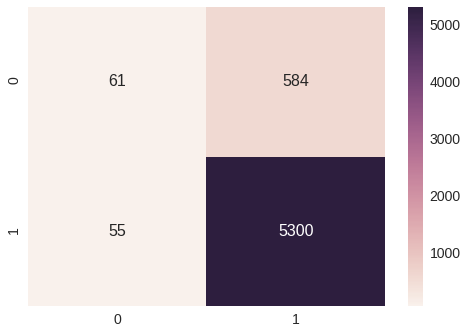

In [69]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on train set: 89.743%
Precision on train set: 0.903
Recall on train set: 0.991
F1-Score on train set: 0.866
Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



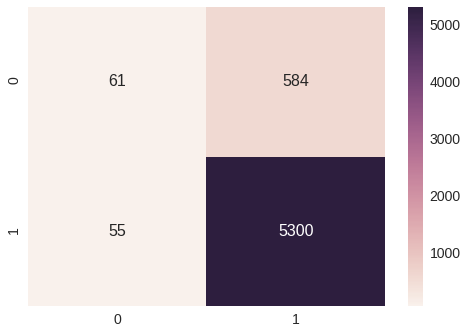

In [70]:
#Testing accuracy on train data
print("Accuracy on train set: %0.3f%%"%(accuracy_score(Y_train, X_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(Y_train, X_pred,pos_label=1)))
print("Recall on train set: %0.3f"%(recall_score(Y_train, X_pred,pos_label=1)))
print("F1-Score on train set: %0.3f"%(f1_score(Y_train, X_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [71]:
# Please write all the code with proper documentation
# List of sentence in X_train text
sent_of_train=[]
for sent in X_train:
    sent_of_train.append(sent.split())

# List of sentence in X_est text
sent_of_test=[]
for sent in X_test:
    sent_of_test.append(sent.split())   
    
# Train your own Word2Vec model using your own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(sent_of_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))

number of words that occured minimum 5 times  5468


In [0]:
# compute average word2vec for each review for X_train .
train_vectors = []; 
for sent in sent_of_train:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
    
# compute average word2vec for each review for X_test .
test_vectors = []; 
for sent in sent_of_test:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: # 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)    

In [73]:
# Please write all the code with proper documentation
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=40)
X_train_vec_dense = svd.fit_transform(train_vectors)
X_test_vec_dense = svd.transform(test_vectors)

knn = KNeighborsClassifier(algorithm='kd_tree',n_jobs=2)
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1,n_jobs=-1)
gsv.fit(X_train_vec_dense,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min


Best HyperParameter:  {'n_neighbors': 15}
Best Accuracy: 89.01%


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  5.3min finished


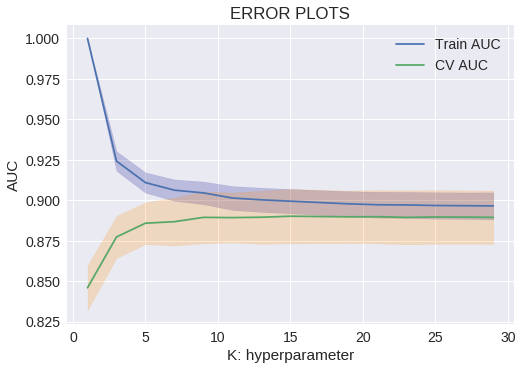

In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
K = [1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]
train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:

knn = KNeighborsClassifier(n_neighbors=15,algorithm='kd_tree')
knn.fit(X_train_vec_dense,Y_train)
Y_pred = knn.predict(X_test_vec_dense)
X_pred = knn.predict(X_train_vec_dense)

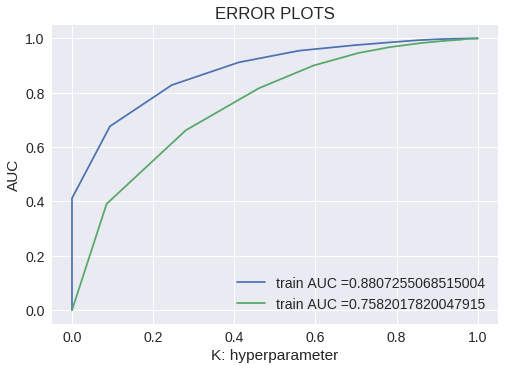

In [77]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(X_train_vec_dense)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test_vec_dense)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Accuracy on test set: 89.333%
Precision on test set: 0.900
Recall on test set: 0.990
F1-Score on test set: 0.858
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



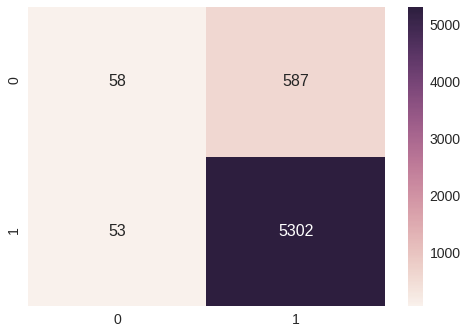

In [78]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on train set: 90.093%
Precision on train set: 0.905
Recall on train set: 0.993
F1-Score on train set: 0.870
Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



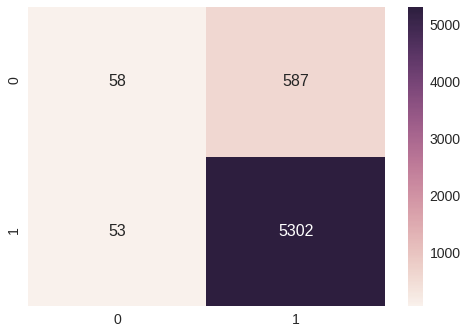

In [79]:
#Testing accuracy on train data
print("Accuracy on train set: %0.3f%%"%(accuracy_score(Y_train, X_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(Y_train, X_pred,pos_label=1)))
print("Recall on train set: %0.3f"%(recall_score(Y_train, X_pred,pos_label=1)))
print("F1-Score on train set: %0.3f"%(f1_score(Y_train, X_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(X_train)

# tfidf words/col-names
tfidf_feat = tf_idf_vect.get_feature_names()

# compute TFIDF Weighted Word2Vec for each review for X_test .
tfidf_test_vectors = []; 
row=0;
for sent in sent_of_test: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1 

In [0]:
# compute TFIDF Weighted Word2Vec for each review for X_train .
tfidf_train_vectors = []; 
row=0;
for sent in sent_of_train: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1  

In [82]:
# Please write all the code with proper documentation
%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=40)
X_train_vec_dense = svd.fit_transform(tfidf_train_vectors)
X_test_vec_dense = svd.transform(tfidf_test_vectors)

knn = KNeighborsClassifier(algorithm='kd_tree',n_jobs=2)
param_grid = {'n_neighbors':[1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train_vec_dense,Y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best HyperParameter:  {'n_neighbors': 27}
Best Accuracy: 88.92%


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:  4.8min finished


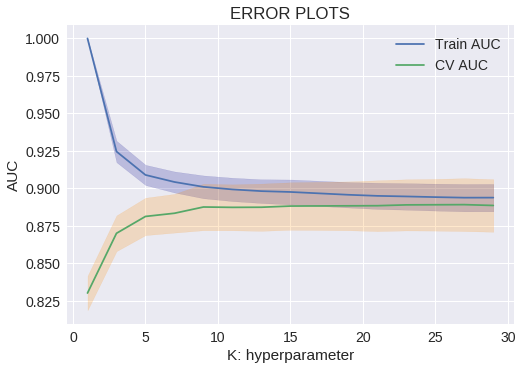

In [83]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
K = [1, 3, 5, 7, 9, 11, 13, 15, 19, 21, 23, 25, 27, 29]
train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

plt.plot(K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [0]:

knn = KNeighborsClassifier(n_neighbors=27)
knn.fit(X_train_vec_dense,Y_train)
Y_pred = knn.predict(X_test_vec_dense)
X_pred = knn.predict(X_train_vec_dense)

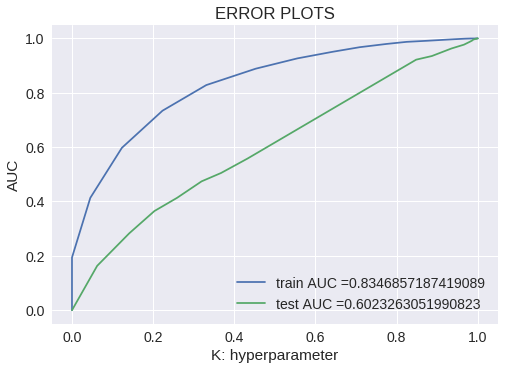

In [86]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, knn.predict_proba(X_train_vec_dense)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, knn.predict_proba(X_test_vec_dense)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Accuracy on test set: 89.000%
Precision on test set: 0.893
Recall on test set: 0.996
F1-Score on test set: 0.843
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



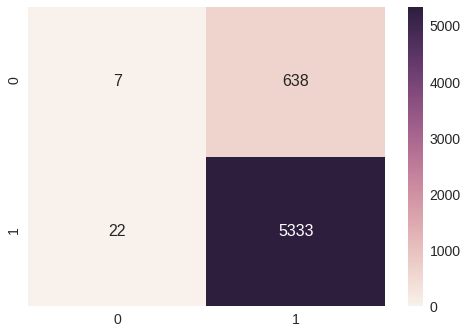

In [87]:
#Testing Accuracy on Test data
from sklearn.neighbors import KNeighborsClassifier

print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, Y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(Y_test, Y_pred,pos_label=1)))
print("Recall on test set: %0.3f"%(recall_score(Y_test, Y_pred,pos_label=1)))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, Y_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on train set: 89.443%
Precision on train set: 0.896
Recall on train set: 0.997
F1-Score on train set: 0.852
Confusion Matrix of train set:
 [ [TN  FP]
 [FN TP] ]



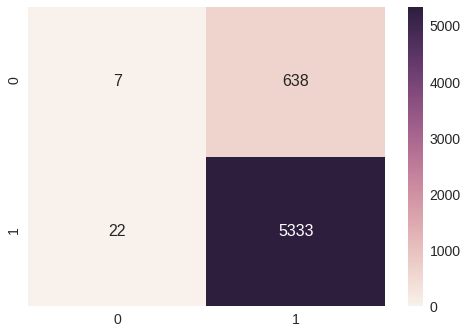

In [88]:
#Testing accuracy on train data
print("Accuracy on train set: %0.3f%%"%(accuracy_score(Y_train, X_pred)*100))
print("Precision on train set: %0.3f"%(precision_score(Y_train, X_pred,pos_label=1)))
print("Recall on train set: %0.3f"%(recall_score(Y_train, X_pred,pos_label=1)))
print("F1-Score on train set: %0.3f"%(f1_score(Y_train, X_pred,pos_label=1,average='weighted')))
print("Confusion Matrix of train set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(Y_test, Y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# [6] Conclusions

In [89]:
# Please compare all your models using Prettytable library
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ["KNN using 'brute' for BoW", "KNN using 'kdTree' for BoW", "KNN using 'brute' for TFIDF", \
        "KNN using 'kdTree' for TFIDF", "KNN using 'brute' for Avg-Word2Vec", "KNN using 'kdTree' for Avg-Word2Vec", \
        "KNN using 'brute' for TFIDF-Word2Vec", "KNN using 'kdTree' for TFIDF-Word2Vec"]

KNN = [29, 27, 29, 27, 29, 15, 29,27]

train_acc = [89.39, 89.50, 89.51, 89.74, 90.21, 90.09, 89.94, 89.44]

test_acc = [88.26, 89.21, 88.46, 89.35, 89.12, 89.33, 87.82, 89.00]

numbering = [1,2,3,4,5,6,7,8]
            
F1score = [0.830, 0.853, 0.834, 0.859, 0.855, 0.858, 0.827, 0.852]            

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best K",KNN)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)
ptable.add_column("F1 score",F1score)

# Printing the Table
print(ptable)

+-------+---------------------------------------+--------+-------------------+---------------+----------+
| S.NO. |                 MODEL                 | Best K | Training Accuracy | Test Accuracy | F1 score |
+-------+---------------------------------------+--------+-------------------+---------------+----------+
|   1   |       KNN using 'brute' for BoW       |   29   |       89.39       |     88.26     |   0.83   |
|   2   |       KNN using 'kdTree' for BoW      |   27   |        89.5       |     89.21     |  0.853   |
|   3   |      KNN using 'brute' for TFIDF      |   29   |       89.51       |     88.46     |  0.834   |
|   4   |      KNN using 'kdTree' for TFIDF     |   27   |       89.74       |     89.35     |  0.859   |
|   5   |   KNN using 'brute' for Avg-Word2Vec  |   29   |       90.21       |     89.12     |  0.855   |
|   6   |  KNN using 'kdTree' for Avg-Word2Vec  |   15   |       90.09       |     89.33     |  0.858   |
|   7   |  KNN using 'brute' for TFIDF-Word2Ve